<a href="https://colab.research.google.com/github/Sam74012/FashionMnist_Classification/blob/main/FashionMNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import random

import matplotlib.pyplot as plt

device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Setup training and testing data
train_data=datasets.FashionMNIST(root="data",
                                 download=True,
                                 train=True,
                                 transform=ToTensor(),
                                 target_transform=None)

test_data=datasets.FashionMNIST(root="data",
                                download=True,
                                train=False,
                                transform=ToTensor(),
                                target_transform=None)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]


In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
classnames=train_data.classes
classnames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx=train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

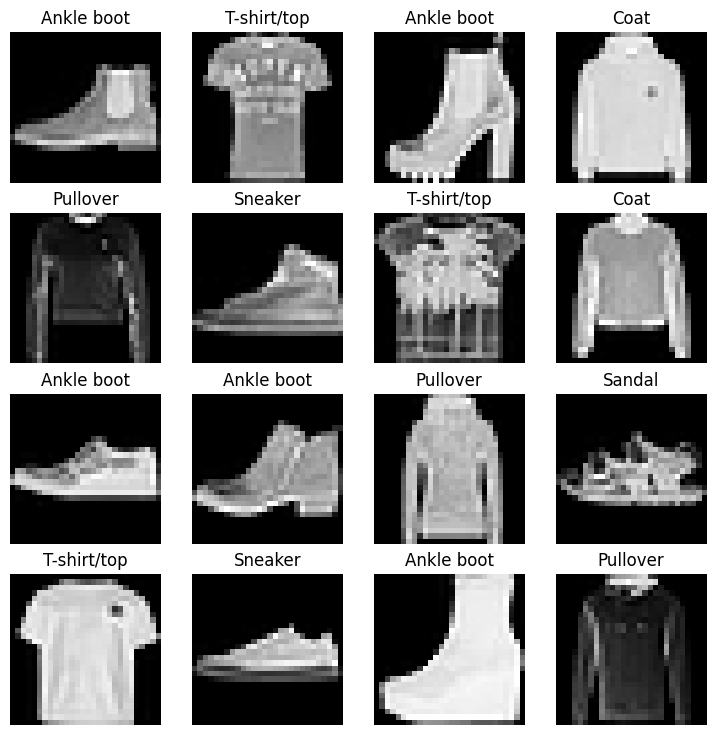

In [ ]:
# Visualizing the data
fig=plt.figure(figsize=(9, 9))
rows=4
cols=4
for i in range(1, rows*cols+1):
  random_idx=random.randint(0, len(train_data))
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(classnames[label])
  plt.axis(False)

In [ ]:
# Preparing dataloader
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

In [ ]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [ ]:
train_features_batch, train_labels_batch= next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
# Building model
class FashionMNISTModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
model_0=FashionMNISTModel(input_shape=784,
                        hidden_units=10,
                        output_shape=len(classnames)).to(device)

model_0

FashionMNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Training loop function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc=0, 0
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred=model(X)
    loss=loss_fn(y_pred, y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_true=y,
                           y_pred=torch.argmax(y_pred, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
# Testing loop function
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc= 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred=model(X)
      test_loss+=loss_fn(test_pred, y)
      test_acc+=accuracy_fn(y_true=y,
                            y_pred=torch.argmax(test_pred, dim=1))

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

In [ ]:
from tqdm.auto import tqdm

epochs=4
# Training and testing loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)

  test_step(model=model_0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59043 | Train accuracy: 79.00%
Test loss: 0.52479 | Test accuracy: 81.35%
Epoch: 1
-------
Train loss: 0.47925 | Train accuracy: 83.12%
Test loss: 0.49312 | Test accuracy: 82.80%
Epoch: 2
-------
Train loss: 0.45477 | Train accuracy: 84.08%
Test loss: 0.48174 | Test accuracy: 82.68%
Epoch: 3
-------
Train loss: 0.44447 | Train accuracy: 84.44%
Test loss: 0.45217 | Test accuracy: 84.19%


In [ ]:
# Evaluating model
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred=model(X)
      loss+=loss_fn(y_pred, y)
      acc+=accuracy_fn(y_true=y, y_pred=torch.argmax(y_pred, dim=1))

    loss/=len(data_loader)
    acc/=len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}


In [ ]:
model_0_results=eval_model(model=model_0,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.4521677792072296,
 'model_acc': 84.185303514377}

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               output_shape: int):
    super().__init__()
    self.block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=256,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256,
                  out_channels=128,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.block_2=nn.Sequential(
        nn.Conv2d(in_channels=128,
                  out_channels=64,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,
                  out_channels=32,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.Classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=32*7*7,
                  out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    return self.Classifier(self.block_2(self.block_1(x)))

In [ ]:
model_1=FashionMNISTModelV1(input_shape=1,
                            output_shape=len(classnames)).to(device)

model_1

FashionMNISTModelV1(
  (block_1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),
                          lr=0.001)

In [ ]:
from tqdm.auto import tqdm
epochs=15

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)

  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.38321 | Train accuracy: 86.07%
Test loss: 0.29116 | Test accuracy: 89.52%
Epoch: 1
-------
Train loss: 0.24914 | Train accuracy: 91.03%
Test loss: 0.26813 | Test accuracy: 90.24%
Epoch: 2
-------
Train loss: 0.21163 | Train accuracy: 92.40%
Test loss: 0.23334 | Test accuracy: 91.49%
Epoch: 3
-------
Train loss: 0.18471 | Train accuracy: 93.34%
Test loss: 0.23084 | Test accuracy: 91.98%
Epoch: 4
-------
Train loss: 0.16431 | Train accuracy: 93.95%
Test loss: 0.22706 | Test accuracy: 92.13%
Epoch: 5
-------
Train loss: 0.14667 | Train accuracy: 94.73%
Test loss: 0.25185 | Test accuracy: 91.78%
Epoch: 6
-------
Train loss: 0.13111 | Train accuracy: 95.20%
Test loss: 0.23497 | Test accuracy: 92.33%
Epoch: 7
-------
Train loss: 0.11782 | Train accuracy: 95.75%
Test loss: 0.25611 | Test accuracy: 91.92%
Epoch: 8
-------
Train loss: 0.10327 | Train accuracy: 96.23%
Test loss: 0.26927 | Test accuracy: 91.94%
Epoch: 9
-------
Train loss: 0.09196 | Train accuracy: 

In [ ]:
model_1_results=eval_model(model=model_1,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.3567121922969818,
 'model_acc': 91.94289137380191}

In [ ]:
# Evaluating model with random predictions
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs = []
model_1.eval()
with torch.inference_mode():
  for sample in test_samples:
    sample = torch.unsqueeze(sample, dim=0).to(device)
    pred_logit = model_1(sample)
    pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
    pred_probs.append(pred_prob.cpu())

pred_classes=torch.argmax(torch.stack(pred_probs), dim=1)
test_labels, pred_classes

([1, 8, 1, 8, 7, 9, 7, 7, 0], tensor([1, 8, 1, 8, 7, 9, 7, 7, 0]))

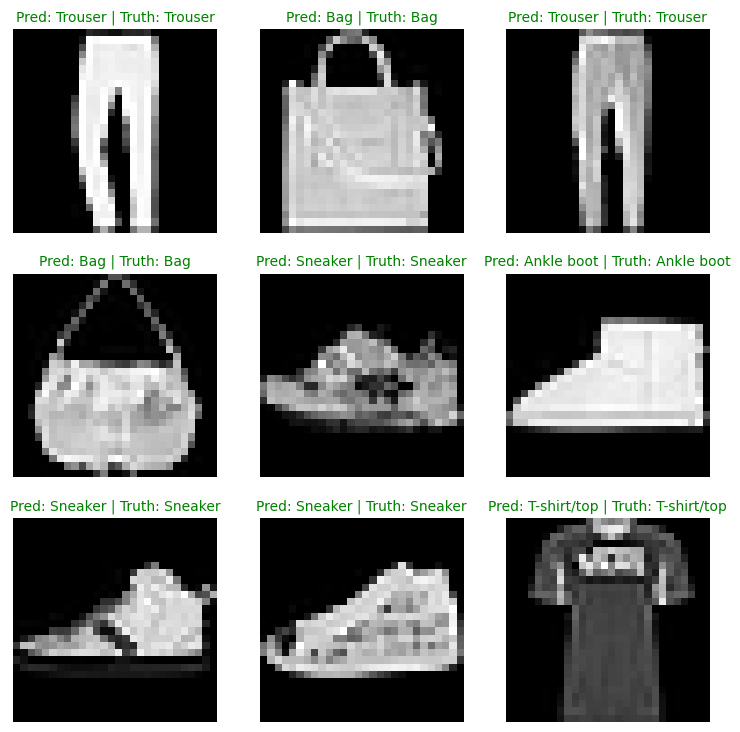

In [ ]:
plt.figure(figsize=(9, 9))
nrows=3
ncols=3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label=classnames[pred_classes[i]]
  truth_label=classnames[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

In [ ]:
y_preds=[]
model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_1(X)
    y_pred = torch.argmax(torch.softmax(y_logit, dim=1), dim=1)
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor.shape

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000])

In [ ]:
# import torchmetrics
try:
  import torchmetrics, mlxtend
except:
  !pip install torchmetrics
  !pip install mlxtend
  import torchmetrics, mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 832.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

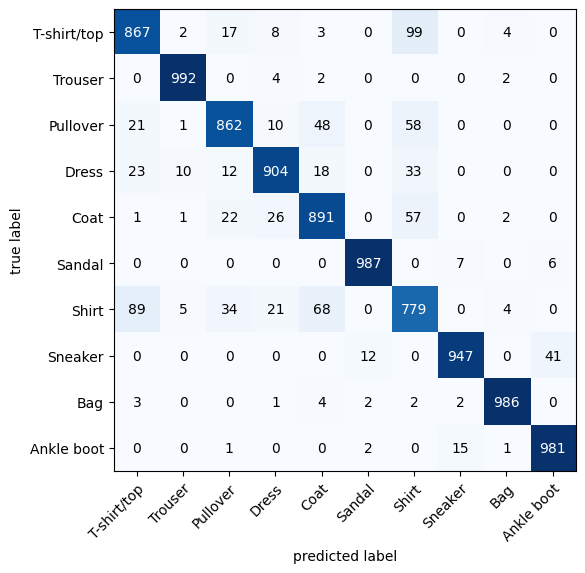

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classnames), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=classnames, # turn the row and column labels into class names
    figsize=(6, 6)
);

In [ ]:
import pandas as pd
compare_results=pd.DataFrame([model_0_results, model_1_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModel,0.452168,84.185304
1,FashionMNISTModelV1,0.356712,91.942891


Text(0, 0.5, 'model')

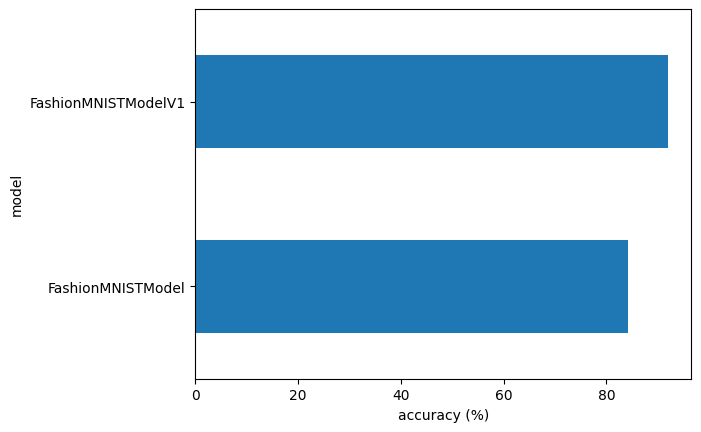

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [ ]:
## Saving and loading
from pathlib import Path

MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME="03_fashion.pth"
MODEL_SAVE_PATH=MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(), f= MODEL_SAVE_PATH)

In [ ]:
loaded_model_1=FashionMNISTModelV1(input_shape=1, output_shape=10)

In [ ]:
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_1.to(device)

FashionMNISTModelV1(
  (block_1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [ ]:
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.3567121922969818,
 'model_acc': 91.94289137380191}

In [ ]:
loaded_model_1_results=eval_model(model=loaded_model_1,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  accuracy_fn=accuracy_fn)
loaded_model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.3567121922969818,
 'model_acc': 91.94289137380191}

In [ ]:
torch.isclose(torch.tensor(model_1_results["model_loss"]),
              torch.tensor(loaded_model_1_results["model_loss"]),
              atol=1e-03)

tensor(True)